# Solving elasticity equations using JuliaFEM

Author(s): Jukka Aho

**Abstract**: Elasticity equations design notes.

###Weak form

Given function spaces
\begin{align}
\boldsymbol{\mathcal{U}} & =\left\{ \boldsymbol{u}\in H^{1}\left(\Omega\right)|\boldsymbol{u}\left(\boldsymbol{X},t\right)=\hat{\boldsymbol{u}}\left(\boldsymbol{X},t\right)\text{ on }\Gamma_{\mathrm{u}}\right\} ,\\
\boldsymbol{\mathcal{V}} & =\left\{ \delta\boldsymbol{u}\in H^{1}\left(\Omega\right)|\delta\boldsymbol{u}\left(\boldsymbol{X}\right)=0\text{ on }\Gamma_{\mathrm{u}}\right\} ,
\end{align}
find $\boldsymbol{u}\in\boldsymbol{\mathcal{U}}$ such that
\begin{equation}
\delta\mathcal{W}:=\int_{\Omega_{0}}\rho_{0}\ddot{\boldsymbol{u}}\cdot\delta\boldsymbol{u}\,\mathrm{d}V_{0}+\int_{\Omega_{0}}\boldsymbol{S}:\delta\boldsymbol{E}\,\mathrm{d}V_{0}-\int_{\Omega_{0}}\hat{\boldsymbol{b}}_{0}\cdot\delta\boldsymbol{u}\,\mathrm{d}V_{0}-\int_{\Gamma_{\sigma}}\hat{\boldsymbol{t}}_{0}\cdot\delta\boldsymbol{u}\,\mathrm{d}A_{0} =0 \qquad\forall\delta\boldsymbol{u}\in\boldsymbol{\mathcal{V}}
\end{equation}

### Some formulas
\begin{align}
J & =\det\left(F\right)\\
I_{c} & =\mbox{tr}\left(C\right)\\
\mathbf{C} & =\mathbf{F}^{\mathrm{T}}\mathbf{F}\\
\mathbf{F} & =\mathbf{I}+\nabla\mathbf{u}\\
\mathbf{E} & =\frac{1}{2}\left(\mathbf{F}^{\mathrm{T}}\mathbf{F}-\mathbf{I}\right)
\end{align}

### Potential energy

\begin{equation}
\underset{u\in\boldsymbol{\mathcal{U}}}{\min}\Pi\left(\mathbf{u}\right)
\end{equation}
\begin{equation}
\Pi\left(\mathbf{u}\right)=\int_{\Omega}\psi\left(\mathbf{u}\right)-\int_{\Omega}\hat{\mathbf{b}}_{0}\cdot\mathbf{u}-\int_{\Gamma_{\sigma}}\hat{\mathbf{t}}_{0}\cdot\mathbf{u}\,\mathrm{d}A_{0}
\end{equation}

### Material models

https://en.wikipedia.org/wiki/Strain_energy_density_function

Saint-Venant-Kirchhoff model https://en.wikipedia.org/wiki/Hyperelastic_material
\begin{equation}
\psi\left(\mathbf{E}\right)=\frac{\lambda}{2}\left[\mbox{tr}\left(\mathbf{E}\right)\right]^{2}+\mu\mbox{tr}\left(\mathbf{E}^2\right)
\end{equation}

neo-Hookean material https://en.wikipedia.org/wiki/Neo-Hookean_solid
\begin{equation}
\psi=\frac{\mu}{2}\left(I_{c}-3\right)-\mu\ln\left(J\right)+\frac{\lambda}{2}\ln\left(J\right)^{2}
\end{equation}

In [2]:
using ForwardDiff
using JuliaFEM: Quad4, Field, FieldSet, IntegrationPoint, Equation, LocalAssembly
using JuliaFEM: get_element, get_basis, grad, get_integration_points
using JuliaFEM: initialize_local_assembly, calculate_local_assembly!
using Logging
using FactCheck
Logging.configure(level=DEBUG)

Logger(root,DEBUG,Base.PipeEndpoint(open, 0 bytes waiting),root)

In [3]:
abstract Elasticity <: Equation
abstract PlaneElasticity <: Elasticity
abstract PlaneStressElasticity <: PlaneElasticity

JuliaFEM.get_unknown_field_name(equation::Elasticity) = "displacement"

""" Plane stress formulation for 4-node bilinear element. """
type CPS4 <: PlaneStressElasticity
    element :: Quad4
    integration_points :: Array{IntegrationPoint, 1}
    global_dofs :: Array{Int64, 1}
end
function CPS4(element::Quad4)
    integration_points = [
        IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0)]
    push!(element, FieldSet("displacement"))
    CPS4(element, integration_points, [])
end

JuliaFEM.size(eq::CPS4) = 8


size (generic function with 63 methods)

## Geometrically non-linear Total Lagrange formulation

### Method 1, tensor notation, automatic differentiation

In [25]:
"""
Calculate internal energy of system. This can be
used to define own material models.

Parameters
----------
equation
    field equation we are solving
ip
    integration point, which can be used to access fields
time
    current time
F
    deformation gradient

Returns
-------
Internal energy of system.
"""
function calculate_internal_energy(equation::Equation, ip::IntegrationPoint, time::Number, F::Matrix)
    element = get_element(equation)
    basis = get_basis(element)

    # material parameters
    young = basis("youngs modulus", ip, time)
    poisson = basis("poissons ratio", ip, time)
    mu = young/(2*(1+poisson))
    lambda = young*poisson/((1+poisson)*(1-2*poisson))
    if isa(equation, PlaneStressElasticity)
        lambda = 2*lambda*mu/(lambda + 2*mu)  # <- correction for 2d
    end

    E = 1/2*(F'*F - I)  # strain
    Wint = 1/2*lambda*trace(E)^2 + mu*trace(E*E')
    # alternative way to calculate this:
    # S = lambda*trace(E)*I + 2*mu*E
    # Wint = 1/2*trace(S*E')
    return Wint
end

function JuliaFEM.get_potential_energy(equation::Elasticity, ip, time; variation=nothing)
    element = get_element(equation)
    basis = get_basis(element)
    dbasis = grad(basis)

    u = basis("displacement", ip, time, variation)
    ∇u = dbasis("displacement", ip, time, variation)
    F = I + ∇u  # deformation gradient

    # internal energy
    Wint = calculate_internal_energy(equation, ip, time, F)

    # external energy -- any volume load?
    Wext = 0.0
    if haskey(element, "displacement volume load")
        b = basis("displacement volume load", ip, time)
        Wext += dot(b, u)
    end

    return Wint - Wext
end

JuliaFEM.has_potential_energy(equation::CPS4) = true

has_potential_energy (generic function with 2 methods)

In [26]:
facts("testing primary field with nodal load versus code aster solution") do
    element = Quad4([1, 2, 3, 4])
    push!(element, FieldSet("geometry", [Field(0.0, Vector[[0.0, 0.0], [10.0, 0.0], [10.0, 1.0], [0.0, 1.0]])]))
    push!(element, FieldSet("youngs modulus", [Field(0.0, 500.0)]))
    push!(element, FieldSet("poissons ratio", [Field(0.0, 0.3)]))
    push!(element, FieldSet("displacement nodal load", [Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, -20.0], [0.0, 0.0]])]))
    equation = CPS4(element)
    
    u0 = Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
    push!(element["displacement"], u0)
    u = zeros(8)
    du = zeros(8)
    fd = [3, 4, 5, 6]
    la = initialize_local_assembly(equation)
    tic()
    for i=1:10
        la = initialize_local_assembly(equation, la)
        calculate_local_assembly!(la, equation)
        du[fd] = la.stiffness_matrix[fd,fd] \ la.force_vector[fd]
        u += du
        new_field = similar(u0, u)
        new_field.time = 1.0
        new_field.increment = i
        push!(element["displacement"], new_field)
        @printf("increment %2d, |du| = %8.5f\n", i, norm(du))
    end
    toc()
    # verified using Code Aster.
    @fact get_basis(element)("displacement", [1.0, 1.0])[2] --> roughly(-4.15546385452579E+00)
end

testing primary field with nodal load versus code aster solution
increment 

delayed_handler (generic function with 4 methods)

 1, |du| =  5.77653
increment  2, |du| =  0.99988
increment  3, |du| =  0.28354
increment  4, |du| =  0.07071
increment  5, |du| =  0.00082
increment  6, |du| =  0.00000
increment  7, |du| =  0.00000
increment  8, |du| =  0.00000
increment  9, |du| =  0.00000
increment 10, |du| =  0.00000
elapsed time: 0.03522289 seconds
1 fact verified.


In [27]:
facts("testing primary field with volume load versus code aster solution") do
    element = Quad4([1, 2, 3, 4])
    push!(element, FieldSet("geometry", [Field(0.0, Vector[[0.0, 0.0], [10.0, 0.0], [10.0, 1.0], [0.0, 1.0]])]))
    push!(element, FieldSet("youngs modulus", [Field(0.0, 500.0)]))
    push!(element, FieldSet("poissons ratio", [Field(0.0, 0.3)]))
    push!(element, FieldSet("displacement volume load",
        [Field(0.0, Vector[[0.0, -10.0], [0.0, -10.0], [0.0, -10.0], [0.0, -10.0]])]))
    equation = CPS4(element)

    u0 = Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
    push!(element["displacement"], u0)
    u = zeros(8)
    du = zeros(8)
    fd = [3, 4, 5, 6]
    la = initialize_local_assembly(equation)
    tic()
    for i=1:10
        la = initialize_local_assembly(equation, la)
        calculate_local_assembly!(la, equation)
        du[fd] = la.stiffness_matrix[fd,fd] \ la.force_vector[fd]
        u += du
        new_field = similar(u0, u)
        new_field.time = 1.0
        new_field.increment = i
        push!(element["displacement"], new_field)
        @printf("increment %2d, |du| = %8.5f\n", i, norm(du))
    end
    toc()
    # verified using Code Aster.
    @fact get_basis(element)("displacement", [1.0, 1.0])[2] --> roughly(-8.77303119819776E+00)
end

testing primary field with volume load versus code aster solution
increment 

delayed_handler (generic function with 4 methods)

 1, |du| = 14.44128
increment  2, |du| =  4.01742
increment  3, |du| =  1.54645
increment  4, |du| =  1.12361
increment  5, |du| =  0.79119
increment  6, |du| =  0.12733
increment  7, |du| =  0.00725
increment  8, |du| =  0.00001
increment  9, |du| =  0.00000
increment 10, |du| =  0.00000
elapsed time: 0.004752839 seconds
1 fact verified.


### Method 2, Voigt notation, analytical linearization

I think I don't need to mention which way is more elegant. Here's the linearization of system is done manually anyway, maybe it has better performance.

In [24]:
""" Plane stress formulation for 4-node bilinear element, manual formulation. """
type CPS4M <: PlaneStressElasticity
    element :: Quad4
    integration_points :: Array{IntegrationPoint, 1}
    global_dofs :: Array{Int64, 1}
end
function CPS4M(element::Quad4)
    integration_points = [
        IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0)]
    push!(element, FieldSet("displacement"))
    CPS4M(element, integration_points, [])
end

JuliaFEM.size(eq::CPS4M) = 8

function JuliaFEM.calculate_local_assembly!(assembly::LocalAssembly, equation::CPS4M, time::Number=Inf)
    initialize_local_assembly(assembly, equation)
    element = get_element(equation)
    basis = get_basis(element)
    dbasis = grad(basis)
    detJ = det(basis)
    ndofs = size(equation)
    nnodes = round(Int, ndofs/2)

    B_L = zeros(3, ndofs)
    B_NL = zeros(4, ndofs)

    for ip in get_integration_points(equation)

        fill!(B_L, 0.0)
        fill!(B_NL, 0.0)

        u = basis("displacement", ip, time)
        ∇u = dbasis("displacement", ip, time)
        young = basis("youngs modulus", ip, time)
        poisson = basis("poissons ratio", ip, time)

        # kinematics
        F = I + ∇u  # deformation gradient
        E = 1/2*(F'*F - I)  # GL strain tensor
        E = [E[1,1], E[2,2], E[1,2]*2]  # go to Voigt

        # constitutive equations -- calculate stress
        D = young/(1-poisson^2) * [1 poisson 0; poisson 1 0; 0 0 1/2*(1-poisson)]
        S = D*E
        T = zeros(4, 4)
        T[1,1] = S[1]
        T[2,2] = S[2]
        T[1,2] = T[2,1] = S[3]
        T[3:4,3:4] = T[1:2,1:2]

        dNdX = dbasis(ip, time)

        # linear part
        for i=1:nnodes
            B_L[1, 2*(i-1)+1] = F[1,1]*dNdX[1,i]
            B_L[1, 2*(i-1)+2] = F[2,1]*dNdX[1,i]
            B_L[2, 2*(i-1)+1] = F[1,2]*dNdX[2,i]
            B_L[2, 2*(i-1)+2] = F[2,2]*dNdX[2,i]
            B_L[3, 2*(i-1)+1] = F[1,1]*dNdX[2,i] + F[1,2]*dNdX[1,i]
            B_L[3, 2*(i-1)+2] = F[2,1]*dNdX[2,i] + F[2,2]*dNdX[1,i]
        end

        # nonlinear part
        for i=1:nnodes
            B_NL[1, 2*(i-1)+1] = dNdX[1,i]
            B_NL[2, 2*(i-1)+1] = dNdX[2,i]
            B_NL[3, 2*(i-1)+2] = dNdX[1,i]
            B_NL[4, 2*(i-1)+2] = dNdX[2,i]
        end

        s = ip.weight*detJ(ip)
        assembly.stiffness_matrix += s*B_L'*D*B_L + s*B_NL'*T*B_NL
        assembly.force_vector += -s*B_L'*S

    end

    if haskey(element, "displacement nodal load")
        assembly.force_vector += element["displacement nodal load"](time)[:]
    end

end

facts("testing primary field with nodal load versus code aster solution") do
    element = Quad4([1, 2, 3, 4])
    push!(element, FieldSet("geometry", [Field(0.0, Vector[[0.0, 0.0], [10.0, 0.0], [10.0, 1.0], [0.0, 1.0]])]))
    push!(element, FieldSet("youngs modulus", [Field(0.0, 500.0)]))
    push!(element, FieldSet("poissons ratio", [Field(0.0, 0.3)]))
    push!(element, FieldSet("displacement nodal load", [Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, -20.0], [0.0, 0.0]])]))
    equation = CPS4M(element)
    
    u0 = Field(0.0, Vector[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
    push!(element["displacement"], u0)
    u = zeros(8)
    du = zeros(8)
    
    fd = [3, 4, 5, 6]
    la = initialize_local_assembly(equation)
    tic()
    for i=1:10
        la = initialize_local_assembly(equation, la)
        calculate_local_assembly!(la, equation)
        du[fd] = la.stiffness_matrix[fd,fd] \ la.force_vector[fd]
        u += du
        new_field = similar(u0, u)
        new_field.time = 1.0
        new_field.increment = i
        push!(element["displacement"], new_field)
        @printf("increment %2d, |du| = %8.5f\n", i, norm(du))
    end
    toc()
    # verified using Code Aster. Noh, toimi se eilen.
    @fact get_basis(element)("displacement", [1.0, 1.0])[2] --> roughly(-4.15546385452579E+00)
end

testing primary field with nodal load versus code aster solution
increment 

delayed_handler (generic function with 4 methods)

 1, |du| =  5.77653
increment  2, |du| =  1.05083
increment  3, |du| =  0.39176
increment  4, |du| =  0.21527
increment  5, |du| =  0.16285
increment  6, |du| =  0.13115
increment  7, |du| =  0.10774
increment  8, |du| =  0.08994
increment  9, |du| =  0.07617
increment 10, |du| =  0.06533
elapsed time: 0.004335419 seconds
  Failure :: (line:-1) :: fact was false
    Expression: ((get_basis(element))("displacement",[1.0,1.0]))[2] --> roughly(-4.15546385452579)
      Expected: -5.091745430627231 ≅ -4.15546385452579
Out of 1 total fact:
  Failed:   1


Time to test again. From last test we know that correct solution is

    [0.0 -0.39914506095474317 -0.07228582695592449 0.0
     0.0 -2.1779892317073504  -2.222244754401764   0.0]

# 3d simulation

We create a new C3D10 element and solve 3d problem.

In [23]:
fid = open("../geometry/3d_beam/palkki.inp")
model = JuliaFEM.parse_abaqus(fid)
close(fid)
model

24-Aug 01:07:34:INFO:root:Registered handlers: Any["ELEMENT","NODE","NSET"]
24-Aug 01:07:34:DEBUG:root:Found NODE section
24-Aug 01:07:35:DEBUG:root:Found ELEMENT section
24-Aug 01:07:35:DEBUG:root:120 elements found
24-Aug 01:07:35:INFO:root:Creating ELSET Body1
24-Aug 01:07:35:DEBUG:root:Found NSET section
24-Aug 01:07:35:DEBUG:root:Creating node set SUPPORT
24-Aug 01:07:35:DEBUG:root:Found NSET section
24-Aug 01:07:35:DEBUG:root:Creating node set LOAD
24-Aug 01:07:35:DEBUG:root:Found NSET section
24-Aug 01:07:35:DEBUG:root:Creating node set TOP


Dict{Any,Any} with 4 entries:
  "nodes"    => Dict{Any,Any}(288=>[97.5,7.5,10.0],11=>[92.5,2.5,5.0],134=>[45.0,10.0,0.0],158=>[2.5,2.5,0.0],160=>[7.5,7.5,0.0],215=>[60.0,0.0,5.0],29=>[2.5,7…
  "elements" => Dict{Any,Any}(68=>[71,144,149,198,51,150,57,43,50,214],2=>[204,199,175,130,207,208,209,3,4,176],89=>[95,78,104,52,127,126,106,60,68,67],11=>[15…
  "elsets"   => Dict{Any,Any}("Body1"=>[1,2,3,4,5,6,7,8,9,10  …  111,112,113,114,115,116,117,118,119,120])
  "nsets"    => Dict{Any,Any}("LOAD"=>[82,84,87,179,197,246,249,256,257],"SUPPORT"=>[108,109,111,155,162,216,225,281,298],"TOP"=>[70,75,76,84,88,90,95,96,98,10…

In [20]:
abstract Tet10 <: CG

"""
Stress/displacement elements. 10-node quadratic tetrahedron.
"""
type C3D10 <: Tet10
    id :: Int
    node_ids :: Array{Int, 1}
    coordinates :: Array{Float64, 2}
    integration_points :: Array{IntegrationPoint, 1}
    attributes :: Dict{ASCIIString, Any}
end

In [21]:
function C3D10(element_id, node_ids)

    # Construct Lagrange basis
    
    P(xi) = [
        1
        xi[1]
        xi[2]
        xi[3]
        xi[1]^2
        xi[2]^2
        xi[3]^2
        xi[1]*xi[2]
        xi[2]*xi[3]
        xi[3]*xi[1]]

    dP(xi) = [
        0 0 0
        1 0 0
        0 1 0
        0 0 1
        2*xi[1] 0 0
        0       2*xi[2] 0
        0       0       2*xi[3]
        xi[2]   xi[1]   0
        0       xi[3]   xi[2]
        xi[3]   0       xi[1]
    ]

    X = [
        0.0 0.0 0.0
        1.0 0.0 0.0
        0.0 1.0 0.0
        0.0 0.0 1.0
        0.5 0.0 0.0
        0.5 0.5 0.0
        0.0 0.5 0.0
        0.0 0.0 0.5
        0.5 0.0 0.5
        0.0 0.5 0.5]

    A = zeros(10, 10)

    for i=1:10
        A[i,:] = P(X[i,:])
    end

    invA = inv(A)
    basis(xi) = invA'*P(xi)
    dbasis(xi) = invA'*dP(xi)

    shape_functions = FunctionSpace(basis, dbasis)

    a = .585410196624969
    b = .138196601125011
    w = .041666666666667

    integration_points = [
        JuliaFEM.IntegrationPoint([a, b, b], w, Dict()),
        JuliaFEM.IntegrationPoint([b, a, b], w, Dict()),
        JuliaFEM.IntegrationPoint([b, b, a], w, Dict()),
        JuliaFEM.IntegrationPoint([b, b, b], w, Dict())]
    
    attributes = Dict("displacement" => zeros(3, 10))

    C3D10(element_id, node_ids, shape_functions, integration_points, attributes)
end

C3D10

In [22]:
"""
1-node point force element for 3d elasticity problem.
"""
type C3D1 <: ContinuumElement
    id :: Int
    node_ids :: Array{Int, 1}
    attributes :: Dict{ASCIIString, Any}
end
function C3D1(element_id, node_ids)
    attributes = Dict(
        "displacement" => zeros(3, 1),
        "displacement nodal load" => zeros(3, 1))
    C3D1(element_id, node_ids, attributes)
end
function get_rhs(el::C3D1)
    return el.attributes["displacement nodal load"]
end
function get_lhs(el::C3D1)
    return None
end

get_lhs (generic function with 4 methods)

In [40]:
function solve_3d_model()
    Logging.debug("Creating elements")
    elements = JuliaFEM.Element[]
    
    E = 90.0e6
    nu = 0.3
    mu = E/(2*(1+nu))
    la = E*nu/((1+nu)*(1-2*nu))
    la = 2*la*mu/(la + 2*mu)

    coordinates = zeros(3, 10)

    Logging.debug("Creating elements")
    for (elid, node_ids) in model["elements"]
        coordinates[:,:] = 0.0
        for (i, nid) in enumerate(node_ids)
            coordinates[:,i] = model["nodes"][nid]
        end
        el = C3D10(elid, node_ids)
        set_attribute(el, "coordinates", copy(coordinates))
        set_attribute(el, "lambda", la)
        set_attribute(el, "mu", mu)
        push!(elements, el)
    end

    # create "dofmap" so that we know how to assemble global stiffness matrix
    dofmap = create_ldof2gdofmap(elements, "displacement")

    # Boundary conditions

    # dirichlet bc, set dx=dy=dz=0 for all nodes in set SUPPORT
    dirichlet_bcs = MPC[]
    for nid in model["nsets"]["SUPPORT"]
        for i=1:3
            push!(dirichlet_bcs, MPC(dofmap[nid][i]))
        end
    end

    # force boundary condition, put -1500000 to 2nd dof for each node in set LOAD
    elcnt = 100000
    loadvec = [0.0, -1500000.0, 0.0]
    for nid in model["nsets"]["LOAD"]
        # set up "point load element"
        elcnt += 1
        el = C3D1(elcnt, [nid])
        set_attribute(el, "displacement nodal load", loadvec)
        push!(elements, el)
    end

    # ndofs = dimension of unknown field in nodes
    solve!(elements, dofmap, dirichlet_bcs; ndofs=3, max_iterations=10)

    # Let's pick maximum absolute displacement in y direction
    maxdisp = 0.0
    for el in elements
        eldisp = el.attributes["displacement"]
        eldispy = eldisp[2,:]
        maxeldisp = maximum(abs(eldispy))
        if maxeldisp > maxdisp
            maxdisp = maxeldisp
        end
    end
    Logging.info("Maximum absolute displacement in y direction: $maxdisp")
    return model, elements, dofmap
end

model, elements, dofmap = solve_3d_model();

22-Aug 21:35:10:DEBUG:root:Creating elements
22-Aug 21:35:10:DEBUG:root:Creating elements
22-Aug 21:35:10:INFO:root:solve!: dofs per node: 3
22-Aug 21:35:10:DEBUG:root:Problem size = 894
22-Aug 21:35:10:DEBUG:root:Starting iteration 1
22-Aug 21:35:10:DEBUG:root:Assembling lhs
22-Aug 21:35:23:DEBUG:root:Assembling rhs
22-Aug 21:35:23:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
22-Aug 21:35:23:DEBUG:root:Added 27 Lagrange multipliers to model
22-Aug 21:35:23:DEBUG:root:Solving system of equations. Total size = 921
22-Aug 21:35:23:DEBUG:root:Solution norm du = 550.6462282437674
22-Aug 21:35:23:DEBUG:root:Starting iteration 2
22-Aug 21:35:23:DEBUG:root:Assembling lhs
22-Aug 21:35:36:DEBUG:root:Assembling rhs
22-Aug 21:35:36:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
22-Aug 21:35:36:DEBUG:root:Added 27 Lagrange multipliers to model
22-Aug 21:35:36:DEBUG:root:Solving system of equations. Total size = 921
22-Aug 21:35:36:DEBUG:roo

    22-Aug 21:35:10:DEBUG:root:Creating elements
    22-Aug 21:35:10:DEBUG:root:Creating elements
    22-Aug 21:35:10:INFO:root:solve!: dofs per node: 3
    22-Aug 21:35:10:DEBUG:root:Problem size = 894
    22-Aug 21:35:10:DEBUG:root:Starting iteration 1
    22-Aug 21:35:10:DEBUG:root:Assembling lhs
    22-Aug 21:35:23:DEBUG:root:Assembling rhs
    22-Aug 21:35:23:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:35:23:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:35:23:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:35:23:DEBUG:root:Solution norm du = 550.6462282437674
    22-Aug 21:35:23:DEBUG:root:Starting iteration 2
    22-Aug 21:35:23:DEBUG:root:Assembling lhs
    22-Aug 21:35:36:DEBUG:root:Assembling rhs
    22-Aug 21:35:36:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:35:36:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:35:36:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:35:36:DEBUG:root:Solution norm du = 126.14054730775176
    22-Aug 21:35:36:DEBUG:root:Starting iteration 3
    22-Aug 21:35:36:DEBUG:root:Assembling lhs
    22-Aug 21:35:49:DEBUG:root:Assembling rhs
    22-Aug 21:35:49:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:35:49:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:35:49:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:35:49:DEBUG:root:Solution norm du = 38.949840553368894
    22-Aug 21:35:49:DEBUG:root:Starting iteration 4
    22-Aug 21:35:49:DEBUG:root:Assembling lhs
    22-Aug 21:36:03:DEBUG:root:Assembling rhs
    22-Aug 21:36:04:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:36:04:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:36:04:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:36:04:DEBUG:root:Solution norm du = 15.167069063650652
    22-Aug 21:36:04:DEBUG:root:Starting iteration 5
    22-Aug 21:36:04:DEBUG:root:Assembling lhs
    22-Aug 21:36:17:DEBUG:root:Assembling rhs
    22-Aug 21:36:17:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:36:17:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:36:17:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:36:17:DEBUG:root:Solution norm du = 9.516311534304958
    22-Aug 21:36:17:DEBUG:root:Starting iteration 6
    22-Aug 21:36:17:DEBUG:root:Assembling lhs
    22-Aug 21:36:32:DEBUG:root:Assembling rhs
    22-Aug 21:36:32:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:36:32:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:36:32:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:36:32:DEBUG:root:Solution norm du = 1.6222822043785954
    22-Aug 21:36:32:DEBUG:root:Starting iteration 7
    22-Aug 21:36:32:DEBUG:root:Assembling lhs
    22-Aug 21:36:46:DEBUG:root:Assembling rhs
    22-Aug 21:36:48:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:36:48:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:36:48:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:36:48:DEBUG:root:Solution norm du = 0.09626397754176579
    22-Aug 21:36:48:DEBUG:root:Starting iteration 8
    22-Aug 21:36:48:DEBUG:root:Assembling lhs
    22-Aug 21:37:07:DEBUG:root:Assembling rhs
    22-Aug 21:37:07:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:37:07:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:37:07:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:37:07:DEBUG:root:Solution norm du = 0.00026304537198068307
    22-Aug 21:37:07:DEBUG:root:Starting iteration 9
    22-Aug 21:37:07:DEBUG:root:Assembling lhs
    22-Aug 21:37:22:DEBUG:root:Assembling rhs
    22-Aug 21:37:22:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:37:22:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:37:22:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:37:22:DEBUG:root:Solution norm du = 2.7245126807720425e-9
    22-Aug 21:37:22:DEBUG:root:Starting iteration 10
    22-Aug 21:37:22:DEBUG:root:Assembling lhs
    22-Aug 21:37:35:DEBUG:root:Assembling rhs
    22-Aug 21:37:35:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
    22-Aug 21:37:35:DEBUG:root:Added 27 Lagrange multipliers to model
    22-Aug 21:37:35:DEBUG:root:Solving system of equations. Total size = 921
    22-Aug 21:37:35:DEBUG:root:Solution norm du = 1.0919112177573261e-13
    22-Aug 21:37:35:DEBUG:root:Converged in 10 iterations.
    22-Aug 21:37:35:INFO:root:Maximum absolute displacement in y direction: 49.40459927455298

22.8.2015 13-14 seconds/assembly.

## Saving results to file

In [28]:
xdoc, xmodel = JuliaFEM.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.xdmf_new_grid(temporal_collection; time=0)

<Grid Name="Grid">
  <Time Value="0"/>
</Grid>


Save geometry to xdmf file

In [29]:
nnodes = length(model["nodes"])
Logging.info("Number of nodes in model: $nnodes")
node_ids = Int64[]
for nid in keys(model["nodes"])
    push!(node_ids, nid)
end
sort!(node_ids)
X = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    X[:,i] = model["nodes"][nid]
end

nelements = length(model["elements"])
Logging.info("Number of elements in model: $nelements")
elmap = zeros(Int64, 11, nelements)
elmap[1,:] = 0x0026
for elid in 1:nelements
    elmap[2:end,elid] = model["elements"][elid]
end

22-Aug 20:53:09:INFO:root:Number of nodes in model: 298
22-Aug 20:53:09:INFO:root:Number of elements in model: 120


In [30]:
JuliaFEM.xdmf_new_mesh(grid, X, elmap)

true

In [31]:
JuliaFEM.xdmf_save_model(xdoc, "/tmp/3d_solid_model.xmf")

10435

Save nodal data to model

In [32]:
nodaldisp = Dict()
for el in elements
    for (i, nid) in enumerate(el.node_ids)
        nodaldisp[nid] = el.attributes["displacement"][:, i]
    end
end
nodaldisp

Dict{Any,Any} with 298 entries:
  288 => [-12.729409015111749,-46.9846345618832,0.009761610393284966]
  11  => [-14.785829217208345,-42.20176974427358,0.008418234114233902]
  158 => [-0.09613238427634156,-0.024925865661713818,-0.021152328599486542]
  215 => [-8.20409899751332,-20.651834887555676,0.003675944651348186]
  134 => [-0.04746289973766305,-13.917505665457174,0.05113049026250106]
  160 => [0.24815357717678269,-0.45087760210227873,0.03912838810489934]
  29  => [0.07844018461547243,-0.0627092438336493,0.004195891729593265]
  131 => [-0.044388456389576496,-13.917981456773019,-0.0438798882444338]
  249 => [-18.540806339609137,-46.66700218188106,0.008827411992911762]
  207 => [-4.7437779792501855,-11.296644899155622,0.02719228049012583]
  173 => [-6.3308244019029285,-30.052183303569294,0.02087205767261999]
  289 => [-11.37815163924305,-43.5423942881868,0.006659559839321376]
  74  => [-1.0030212040099715,-18.13510354497542,0.026360938873556356]
  201 => [-6.115145748129304,-15.075793

In [33]:
u = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    u[:,i] = nodaldisp[nid]
end
u

3x298 Array{Float64,2}:
 -0.328537     -0.581456     -1.94415      -2.25956      -1.65873      -1.02996     …  -0.151833   -0.572535    -0.320967    -1.37494     -0.922318    0.0
 -2.97468      -4.52837     -10.717       -11.9348      -14.9046      -12.2747         -1.683      -4.49601     -2.94077     -8.4008      -6.32738     0.0
 -0.000439894   0.00176042    0.00267874    0.00357279    0.00431665    0.00380978      0.0048871   0.00163786   0.00332861   0.00422365   0.00304404  0.0

In [34]:
JuliaFEM.xdmf_new_field(grid, "Displacement", "nodes", u)

true

In [35]:
JuliaFEM.xdmf_save_model(xdoc, "/tmp/3d_solid_model.xmf")

28138

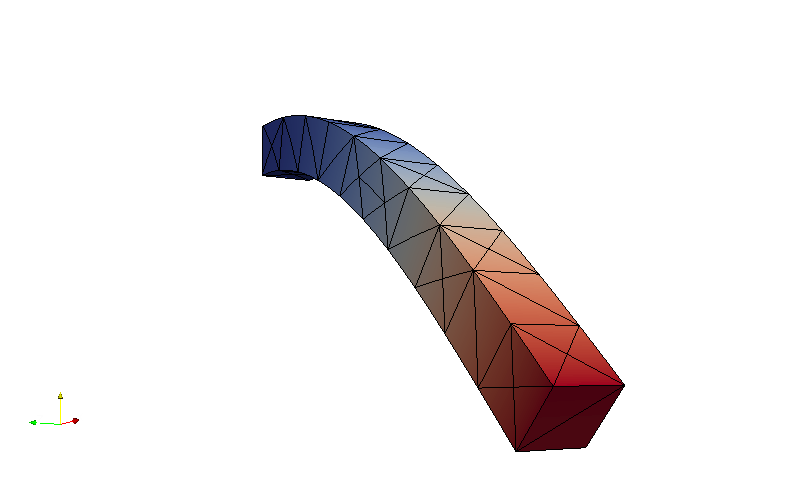

In [36]:
using PyCall
@pyimport IPython.display as d
d.Image("/tmp/3d_solid_model.png")

## Another 3d example

In [ ]:
using JuliaFEM.abaqus_reader
fid = open("../geometry/piston/piston_45510_P1.inp")
#fid = open("../geometry/piston/piston_8789_P1.inp")
model = JuliaFEM.abaqus_reader.parse_abaqus(fid)
close(fid)
model

In [ ]:
# Construct linear Lagrange basis
P(xi) = [
    1
    xi[1]
    xi[2]
    xi[3]]
dP(xi) = [
    0 0 0
    1 0 0
    0 1 0
    0 0 1]
X = [
    0.0 0.0 0.0
    1.0 0.0 0.0
    0.0 1.0 0.0
    0.0 0.0 1.0]
A = zeros(4, 4)
for i=1:4
    A[i,:] = P(X[i,:])
end
invA = inv(A)
basis(xi) = invA'*P(xi)
dbasis(xi) = invA'*dP(xi)

In [ ]:
function solve_3d_model()
    Logging.debug("Creating elements")
    elements = JuliaFEM.Element[]
    coordinates = zeros(3, 4)

    integration_points = [
        JuliaFEM.IntegrationPoint([0.25, 0.25, 0.25], 1/6, Dict())
    ]

    for (elid, node_ids) in model["elements"]
        coordinates[:,:] = 0.0
        for (i, nid) in enumerate(node_ids)
            coordinates[:,i] = model["nodes"][nid]
        end


        E = 90.0e6
        nu = 0.3
        mu = E/(2*(1+nu))
        la = E*nu/((1+nu)*(1-2*nu))
        #la = 2*la*mu/(la + 2*mu)
        attributes = Dict()
        el = JuliaFEM.Element(elid, node_ids, basis, dbasis, integration_points, attributes)
        el.attributes["coordinates"] = copy(coordinates)
        el.attributes["lambda"] = la
        el.attributes["mu"] = mu
        el.attributes["displacement"] = zeros(3, 4)
        push!(elements, el)
    end

    # create "dofmap" so that we know how to assemble global stiffness matrix
    dofmap = create_ldof2gdofmap(elements, "displacement")

    # Boundary conditions

    # dirichlet bc, set dx=dy=dz for all nodes in set SUPPORT
    bc_support = BC(Int64[], Float64[])
    for nid in model["nsets"]["SUPPORT"]
        for i=1:3
            push!(bc_support.dofs, dofmap[nid][i])
            push!(bc_support.values, 0.0)
        end
    end

    # force boundary condition, put -1 to 2nd dof for each node in set LOAD
    bc_load = BC(Int64[], Float64[])
    for nid in model["nsets"]["LOAD"]
        push!(bc_load.dofs, dofmap[nid][3])
        push!(bc_load.values, -1500000.0)
    end

    #solve!(elements, [bc1], [bc2]; max_iterations=7)
    neumann_bcs = [bc_load]
    dirichlet_bcs = [bc_support]
    # ndofs = dimension of unknown field in nodes
    solve!(elements, dofmap, neumann_bcs, dirichlet_bcs; ndofs=3, max_iterations=10)

    # Let's pick maximum absolute displacement in y direction
    maxdisp = 0.0
    for el in elements
        eldisp = el.attributes["displacement"]
        eldispy = eldisp[2,:]
        maxeldisp = maximum(abs(eldispy))
        if maxeldisp > maxdisp
            maxdisp = maxeldisp
        end
    end
    Logging.info("Maximum absolute displacement in y direction: $maxdisp")
    return model, elements, dofmap
end

model, elements, dofmap = solve_3d_model();

In [ ]:
xdoc, xmodel = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)

nnodes = length(model["nodes"])
Logging.info("Number of nodes in model: $nnodes")
node_ids = Int64[]
for nid in keys(model["nodes"])
    push!(node_ids, nid)
end
sort!(node_ids)
X = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    X[:,i] = model["nodes"][nid]
end

nelements = length(model["elements"])
Logging.info("Number of elements in model: $nelements")
elmap = zeros(Int64, 5, nelements)
elmap[1,:] = 0x006 # for tet4
for (i, elid) in enumerate(keys(model["elements"]))
    elmap[2:end, i] = model["elements"][elid]
end

xdmf_new_mesh(grid, X, elmap)

nodaldisp = Dict()
for el in elements
    for (i, nid) in enumerate(el.node_ids)
        nodaldisp[nid] = el.attributes["displacement"][:, i]
    end
end

u = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    u[:,i] = nodaldisp[nid]
end

JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u)

JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/piston.xmf")


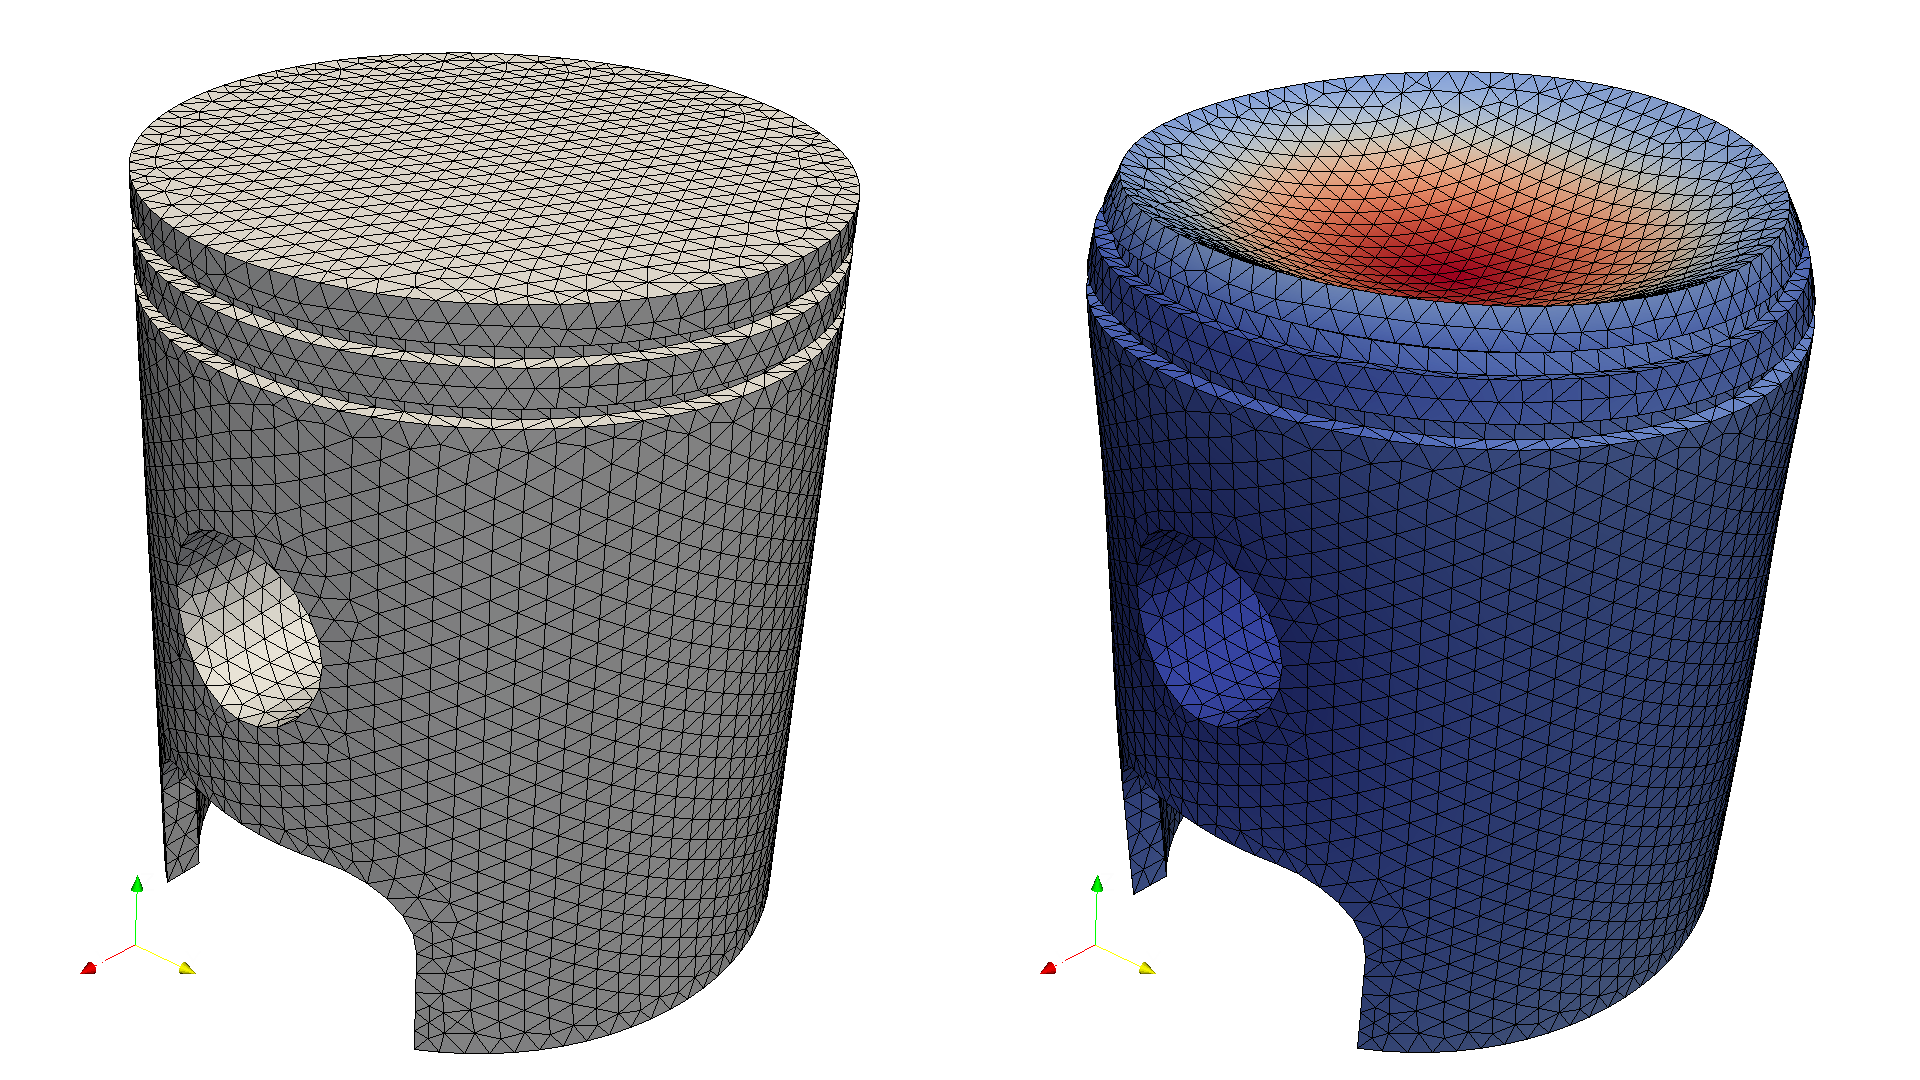

In [37]:
d.Image("/tmp/piston.png")

In [43]:
using ForwardDiff

In [51]:
f(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);

In [52]:
x = rand(5)

5-element Array{Float64,1}:
 0.903617
 0.97582 
 0.36872 
 0.233261
 0.213665

In [53]:
f(x)

2.5477827220775753

In [54]:
g = ForwardDiff.gradient(f);
g(x)

5-element Array{Float64,1}:
 0.906762
 0.860405
 1.35153 
 1.59159 
 1.64713 

In [55]:
typeof(g)

Function

In [56]:
j = ForwardDiff.jacobian(g)

LoadError: LoadError: MethodError: `grad` has no method matching grad(::Function)
while loading In[56], in expression starting on line 1